In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import operator
import matplotlib.pyplot as plt
from datetime import timedelta

1. Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов) 

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (5 баллов)

3. По каждому товару определить, в какой день недели товар чаще всего покупается. (5 баллов)

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов) 

5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти тут. (10 баллов)

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. Описание подхода можно найти тут. (35 баллов)

Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться покупкой. Обосновать свой выбор ты можешь с помощью фактов оплат, статусов заказов и других имеющихся данных.

Файлы:

     olist_customers_datase.csv — таблица с уникальными идентификаторами пользователей

customer_id — позаказный идентификатор пользователя
customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)
customer_zip_code_prefix —  почтовый индекс пользователя
customer_city —  город доставки пользователя
customer_state —  штат доставки пользователя

    olist_orders_dataset.csv —  таблица заказов

order_id —  уникальный идентификатор заказа (номер чека)
customer_id —  позаказный идентификатор пользователя
order_status —  статус заказа
order_purchase_timestamp —  время создания заказа
order_approved_at —  время подтверждения оплаты заказа
order_delivered_carrier_date —  время передачи заказа в логистическую службу
order_delivered_customer_date —  время доставки заказа
order_estimated_delivery_date —  обещанная дата доставки

    olist_order_items_dataset.csv —  товарные позиции, входящие в заказы

order_id —  уникальный идентификатор заказа (номер чека)
order_item_id —  идентификатор товара внутри одного заказа
product_id —  ид товара (аналог штрихкода)
seller_id — ид производителя товара
shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике
price —  цена за единицу товара
freight_value —  вес товара

— Пример структуры данных можно визуализировать по order_id == 00143d0f86d6fbd9f9b38ab440ac16f5

Уникальные статусы заказов в таблице olist_orders_dataset:

    created —  создан
    approved —  подтверждён
    invoiced —  выставлен счёт
    processing —  в процессе сборки заказа
    shipped —  отгружен со склада
    delivered —  доставлен пользователю 
    unavailable —  недоступен
    canceled —  отменён

#### Для начала считываем все данные, проверяем количество строк, типы данных, наличие пропущенных значений, наличие дубликатов, переводим даты к типу datetime

In [2]:
customers = pd.read_csv('C:/Users/POD/!DA/olist_customers_dataset.csv')
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [3]:
customers.shape

(99441, 5)

In [4]:
customers.dtypes

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

In [5]:
customers.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [6]:
customers.loc[customers.duplicated()]

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state


#### ________________________________________________________________________________________________________________

In [7]:
orders = pd.read_csv('C:/Users/POD/!DA/olist_orders_dataset.csv', parse_dates=[3,4,5,6,7])
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [8]:
orders.shape

(99441, 8)

In [9]:
orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [10]:
orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [11]:
orders.loc[orders.duplicated()]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date


#### ________________________

In [12]:
items = pd.read_csv('C:/Users/POD/!DA/olist_order_items_dataset.csv', parse_dates=[4])
items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [13]:
items.shape

(112650, 7)

In [14]:
items.dtypes

order_id                       object
order_item_id                   int64
product_id                     object
seller_id                      object
shipping_limit_date    datetime64[ns]
price                         float64
freight_value                 float64
dtype: object

In [15]:
items.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [16]:
items.loc[items.duplicated()]

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value


In [17]:
#проверила, что для уникального заказа только один статус в дф, последний
orders.groupby('order_id').agg({'order_status': 'count'}).query('order_status>1')

,order_status
order_id,


In [18]:
#смотрю на данные по заказам, где нет метки об оплате (NaT). Какие у них статусы.
orders.loc[orders['order_approved_at'].isna()]\
    .order_status.unique()

array(['canceled', 'delivered', 'created'], dtype=object)

In [19]:
# а что это за заказы, которые были доставлены, но метки об оплате нет
orders.merge(items, how = 'left', on='order_id')\
        .query('order_approved_at.isna() & order_status == "delivered"', engine='python')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
6009,e04abd8149ef81b95221e88f6ed9ab6a,2127dc6603ac33544953ef05ec155771,delivered,2017-02-18 14:40:00,NaT,2017-02-23 12:04:47,2017-03-01 13:25:33,2017-03-17,1.0,0e20a07ca1714df21f9b07ca3bf7c682,4e7c18b98d84e05cbae3ff0ff03846c2,2017-02-22 13:40:00,309.90,39.11
18860,8a9adc69528e1001fc68dd0aaebbb54a,4c1ccc74e00993733742a3c786dc3c1f,delivered,2017-02-18 12:45:31,NaT,2017-02-23 09:01:52,2017-03-02 10:05:06,2017-03-21,1.0,2c2b6a28924791234bd386bddb17512e,a4b6b9b992b46e9ef863637af96e04bc,2017-02-22 11:45:31,379.00,17.86
21661,7013bcfc1c97fe719a7b5e05e61c12db,2941af76d38100e0f8740a374f1a5dc3,delivered,2017-02-18 13:29:47,NaT,2017-02-22 16:25:25,2017-03-01 08:07:38,2017-03-17,1.0,583916a5dae918f5e89baec139141c54,3481aa57cd91f9f9d3fa1fa12d9a3bf7,2017-02-22 12:29:47,49.99,15.53
25796,5cf925b116421afa85ee25e99b4c34fb,29c35fc91fc13fb5073c8f30505d860d,delivered,2017-02-18 16:48:35,NaT,2017-02-22 11:23:10,2017-03-09 07:28:47,2017-03-31,1.0,c6dd917a0be2a704582055949915ab32,7a67c85e85bb2ce8582c35f2203ad736,2017-02-22 15:48:35,79.99,26.82
26359,12a95a3c06dbaec84bcfb0e2da5d228a,1e101e0daffaddce8159d25a8e53f2b2,delivered,2017-02-17 13:05:55,NaT,2017-02-22 11:23:11,2017-03-02 11:09:19,2017-03-20,1.0,c6dd917a0be2a704582055949915ab32,7a67c85e85bb2ce8582c35f2203ad736,2017-02-21 12:05:55,79.99,15.77
30541,c1d4211b3dae76144deccd6c74144a88,684cb238dc5b5d6366244e0e0776b450,delivered,2017-01-19 12:48:08,NaT,2017-01-25 14:56:50,2017-01-30 18:16:01,2017-03-01,1.0,5ab02ca028398131a5ae91401eb49788,80e6699fe29150b372a0c8a1ebf7dcc8,2017-01-23 12:48:08,39.99,14.52
43631,d69e5d356402adc8cf17e08b5033acfb,68d081753ad4fe22fc4d410a9eb1ca01,delivered,2017-02-19 01:28:47,NaT,2017-02-23 03:11:48,2017-03-02 03:41:58,2017-03-27,1.0,cae2e38942c8489d9d7a87a3f525c06b,cca3071e3e9bb7d12640c9fbe2301306,2017-02-26 01:28:47,149.80,13.63
44820,d77031d6a3c8a52f019764e68f211c69,0bf35cac6cc7327065da879e2d90fae8,delivered,2017-02-18 11:04:19,NaT,2017-02-23 07:23:36,2017-03-02 16:15:23,2017-03-22,1.0,02a79d79e818ad0be36cfc843a6af7ad,cb3dd9ce66268c7a3ca7241ac70ab58c,2017-02-25 10:04:19,28.99,10.96
55152,7002a78c79c519ac54022d4f8a65e6e8,d5de688c321096d15508faae67a27051,delivered,2017-01-19 22:26:59,NaT,2017-01-27 11:08:05,2017-02-06 14:22:19,2017-03-16,1.0,c3b271f47e73d0c9ccf1b43b7606c705,cca3071e3e9bb7d12640c9fbe2301306,2017-01-29 22:26:59,45.90,14.52
70281,2eecb0d85f281280f79fa00f9cec1a95,a3d3c38e58b9d2dfb9207cab690b6310,delivered,2017-02-17 17:21:55,NaT,2017-02-22 11:42:51,2017-03-03 12:16:03,2017-03-20,1.0,4fd676d9c4723d475026e40aeae56957,5fd924b4836098a5be0ecf81ba054ce0,2017-02-21 16:21:55,135.00,19.23


**Покупкой в данном проекте считаю заказ, у которого прошло подтверждение оплаты (значение order_approved_at не NaT), а ткаже заказы с пустой меткой order_approved_at, но в статусе delivered. 
Факт оплаты важен, чтобы считать, что это не по ошибке покупатель оформил заказ. Но если даже метки об облате нет, а заказ в статусе delivered, возможно произошла ошибка в логировании (будем считать, что в логировании подтверждения оплаты, а не статуса заказа, т.к. время доставок тоже зафиксировано).
Дальнейшие причины, почему товар был не доставлен, или заказ был отменен, можно изучать дополнительно.
Заказов с пустой меткой о подтверждении оплаты не много - менее одного процента от всех данных.**

### 1. Сколько у нас пользователей, которые совершили покупку только один раз? 

In [20]:
orders.merge(customers, how = 'left', on = 'customer_id')\
        .query('order_approved_at != "NaT" or (order_approved_at.isna() and order_status == "delivered")', engine='python')\
        .groupby('customer_unique_id', as_index = False).agg({'order_id': 'count'})\
        .rename(columns = {'order_id': 'orders_quantity'})\
        .query('orders_quantity == 1')\
        .orders_quantity.sum()

93061

Покупку совершили только один раз 93061 пользователей

In [21]:
# Мне показалось большим число пользователей с одной покупкой. Далее смотрю, как распределились остальные пользователи по количеству покупок
orders.merge(customers, how = 'left', on = 'customer_id')\
        .query('order_approved_at != "NaT" or (order_approved_at.isna() and order_status == "delivered")', engine='python')\
        .groupby('customer_unique_id', as_index = False).agg({'order_id': 'count'})\
        .rename(columns = {'order_id': 'orders_quantity', 'customer_unique_id': 'customers'})\
        .groupby('orders_quantity',  as_index = False).agg({'customers': 'count'})

,orders_quantity,customers
0,1,93061
1,2,2709
2,3,191
3,4,30
4,5,8
5,6,6
6,7,3
7,9,1
8,17,1


### 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

Для ответа на этот вопрос, будем смотреть только на "купленные" заказы.

Также проверим гипотезу, что от части заказов отказались из-за того, что продавец не успел вовремя доставить их логистической компании. Для проверки этой гипотезы найдем минимальную дату доставки логистам для каждого заказа и добавим ее к датафрейму с заказами.

Для дальнейшего анализа отфильтруем датафрейм по совершенным "покупкам" и статусам Unavailable и Canceled, остальные статусы говорят, что заказ еще в процессе.

In [22]:
min_delivery_date = items.groupby('order_id', as_index = False).agg({'shipping_limit_date': 'min'})

orders_nd = orders.merge(min_delivery_date, how = 'left', on = 'order_id')\
                    .query('(order_status == "unavailable" or order_status == "canceled") and order_approved_at.isna() == False', engine='python')

# выделяем месяц и год в отдельные столбцы для анализа
orders_nd['purchase_year'] = orders_nd.order_approved_at.dt.year 
orders_nd['purchase_month'] = orders_nd.order_approved_at.dt.month

# заказы отмененные и не доставленные логистической компании
orders_nd['not_delivered_to_carrier'] = pd.Series(orders_nd.order_delivered_carrier_date.isna())

# заказы доставленные логистической компании, но с опозданием, из-за чего, наверняка и были отменены
orders_nd['delivered_to_carrier_late'] = pd.Series(orders_nd.shipping_limit_date < orders_nd.order_delivered_carrier_date)

# заказы отмененные и не доставленные клиенту
orders_nd['not_delivered_to_client'] = pd.Series(orders_nd.not_delivered_to_carrier == False) & (orders_nd.order_delivered_customer_date.isna())

# заказы доставленные клиенту, но с опозданием относительно предварительной даты доставки, из-за чего, возможно, и были отменены
orders_nd['delivered_to_client_late'] = pd.Series(orders_nd.order_delivered_customer_date > orders_nd.order_estimated_delivery_date)
orders_nd = orders_nd.astype({'purchase_year': 'int64', 'purchase_month': 'int64'})

# группируем по месяцам и подсчитываем количество недоставленных заказов  в каждый месяц по группам
orders_nd = orders_nd.groupby(['order_status', 'purchase_year', 'purchase_month'], as_index = False).agg({'not_delivered_to_carrier': 'sum',\
                                                                         'delivered_to_carrier_late': 'sum',\
                                                                         'not_delivered_to_client': 'sum',\
                                                                         'delivered_to_client_late': 'sum'})

# группируем по статусам заказа, считаем среднее в месяц
orders_nd.groupby('order_status').agg({'not_delivered_to_carrier': 'mean',\
                                        'delivered_to_carrier_late': 'mean',\
                                        'not_delivered_to_client': 'mean',\
                                        'delivered_to_client_late': 'mean'})


,not_delivered_to_carrier,delivered_to_carrier_late,not_delivered_to_client,delivered_to_client_late
order_status,,,,
canceled,19.47619,0.47619,3.285714,0.047619
unavailable,29.00000,0.00000,0.000000,0.000000


Т.о. в среднем недоставляется:

 - из-за недоступности товара - 29 заказов в месяц,
 - из-за отмены до момента передачи в логистическую компанию - 19 заказов в месяц,
 - из-за отмены, в случае опоздания продавца к сроку передачи товара логистической компании - 1 заказ в 2-3 месяца,
 - из-за отмены заказа, когда он уже был в пути - 3 заказа в месяц,
 - из-за отмены заказа по причине (предположительно) опоздания к предварительно озвученному сроку доставки - 1 заказ за весь период.

### 3. По каждому товару определить, в какой день недели товар чаще всего покупается.

Для ответа на этот вопрос, будем смотреть только на "купленные" заказы.

Для анализа добавим в таблицу с товарами данные из таблицы по заказам. Помимо прочих оставим случаи, когда в заказе несколько одинаковых товаров, не будем удалять такие дубликаты.

По этому вопросу мне кажется логичным брать день недели из даты формирования заказа, т.е. день когда пользователь решил купить товар. Остальные шаги могли произойти и позже.


In [23]:
products = items.merge(orders, how = 'left', on = 'order_id')\
                .query('order_approved_at.isna() == False', engine='python') #фильтруем по "покупкам"

#создаем колонку с днем недели, где 0 - понедельник, 6 - воскресенье
products['purchase_weekday'] = products.order_purchase_timestamp.dt.weekday 

#формируем таблицу с продуктом и количеством заказов по дням недели
products = products.groupby(['product_id', 'purchase_weekday'], as_index=False).agg({'order_id':'count'})\
        .rename(columns = {'order_id': 'purchase_quantity'})
products

,product_id,purchase_weekday,purchase_quantity
0,00066f42aeeb9f3007548bb9d3f33c38,6,1
1,00088930e925c41fd95ebfe695fd2655,1,1
2,0009406fd7479715e4bef61dd91f2462,3,1
3,000b8f95fcb9e0096488278317764d19,2,1
4,000b8f95fcb9e0096488278317764d19,4,1
...,...,...,...
61216,fffdb2d0ec8d6a61f0a0a0db3f25b441,1,2
61217,fffdb2d0ec8d6a61f0a0a0db3f25b441,3,1
61218,fffdb2d0ec8d6a61f0a0a0db3f25b441,4,1
61219,fffdb2d0ec8d6a61f0a0a0db3f25b441,6,1


In [24]:
#выбирем для каждого товара день недели, где заказы были макисмальными. 
idx = products.groupby('product_id')['purchase_quantity'].transform(max) == products['purchase_quantity']

products_max = products[idx]

#В этой таблице будут дубликаты, поскольку есть товары для которых число покупок одинаково в разные дни недели.
#На мой взгляд убирать эти дубликаты не нужно, информация может быть использована дальше для анализа.
products_max

,product_id,purchase_weekday,purchase_quantity
0,00066f42aeeb9f3007548bb9d3f33c38,6,1
1,00088930e925c41fd95ebfe695fd2655,1,1
2,0009406fd7479715e4bef61dd91f2462,3,1
3,000b8f95fcb9e0096488278317764d19,2,1
4,000b8f95fcb9e0096488278317764d19,4,1
...,...,...,...
61213,fff6177642830a9a94a0f2cba5e476d1,6,1
61214,fff81cc3158d2725c0655ab9ba0f712c,0,1
61215,fff9553ac224cec9d15d49f5a263411f,4,1
61216,fffdb2d0ec8d6a61f0a0a0db3f25b441,1,2


In [25]:
# для информации товары-"дубликаты"
products_max.loc[products_max.duplicated('product_id')]

,product_id,purchase_weekday,purchase_quantity
4,000b8f95fcb9e0096488278317764d19,4,1
28,002159fe700ed3521f46cfcf6e941c76,5,2
43,0030e635639c898b323826589761cf23,4,1
45,003128f981470c3e5a2e7445e4a771cd,6,1
52,003dbcabcf8e3231de657c7d9f9a5eba,2,1
...,...,...,...
61193,ffe0fc4e02c3559643ac063fa5cf9d07,4,1
61195,ffe75578163d45caa52bca3529cb511e,3,1
61197,ffe8083298f95571b4a66bfbc1c05524,4,1
61204,ffef256879dbadcab7e77950f4f4a195,1,2


### 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

Также будем использовать только заказы, по которым "покупка" была завершена.

Для ответа в таблицу с заказами добавим данные по покупателям.

Результирующий датафрейм шага ниже и будет ответом на вопрос.

In [26]:
cus_purchase = orders.merge(customers, how = 'left', on = 'customer_id')\
        .query('order_approved_at.isna() == False', engine='python') #фильтруем по "покупкам"

#делаем колонку с количеством недель в месяце покупки
cus_purchase['weeks_in_month'] = cus_purchase.order_approved_at.dt.daysinmonth/7 

#создаем колонку с периодом покупки (год и месяц)
cus_purchase['purchase_period'] = cus_purchase.order_approved_at.dt.to_period('M')

#считаем количество покупок по месяцам
cus_purchase = cus_purchase.groupby(['customer_unique_id', 'purchase_period'], as_index=False).agg({'order_id': 'count', 'weeks_in_month': 'min'})\
            .rename(columns = {'order_id': 'purchase_quantity'})

#создаем колонку и расчитываем среднее число покупок в неделю по месяцам для каждого пользователя
cus_purchase['mean_purchase_quantity'] = cus_purchase.purchase_quantity/cus_purchase.weeks_in_month

cus_purchase

,customer_unique_id,purchase_period,purchase_quantity,weeks_in_month,mean_purchase_quantity
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,1,4.428571,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,1,4.428571,0.225806
2,0000f46a3911fa3c0805444483337064,2017-03,1,4.428571,0.225806
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,1,4.428571,0.225806
4,0004aac84e0df4da2b147fca70cf8255,2017-11,1,4.285714,0.233333
...,...,...,...,...,...
97907,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06,1,4.285714,0.233333
97908,fffea47cd6d3cc0a88bd621562a9d061,2017-12,1,4.428571,0.225806
97909,ffff371b4d645b6ecea244b27531430a,2017-02,1,4.000000,0.250000
97910,ffff5962728ec6157033ef9805bacc48,2018-05,1,4.428571,0.225806


### 5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.

Для анализа возьмем датафрейм из предыдущего шага (уже отфильтрован по покупкам, содержит уникальный id покупателя и период покупки. Создадим колонку с периодом, когда произошла первая покупка, т.е. для каждого id пропишем минимальный период.

Затем создадим новый df с когортами, куда возьмем только пользователей с первыми покупками в 2017 году, поскольку по заданию retenion нужно смотреть с января по декабрь. 2017 - единственный период в датасете, который содержит все месяцы. Далее сгруппируем покупателей в когорты по месяцу первой покупки.

In [27]:
cus_purchase['first_purchase'] = cus_purchase.groupby('customer_unique_id').purchase_period.transform(min)


cohort = cus_purchase.query('"2017-01" <= first_purchase <= "2017-12"')\
                    .groupby(['first_purchase', 'purchase_period'], as_index=False)\
                    .agg(customer_count = ('customer_unique_id', 'nunique')) #добавляем колонку с количеством покупателей в когорте

# создаем колонку с номером периода повторной поупки
cohort['period'] = (cohort['purchase_period'] - cohort['first_purchase']).apply(operator.attrgetter('n'))

# разворачиваем дф, чтобы видеть данные по каждому периоду
cohort_pivoted = cohort.pivot_table(index='first_purchase', columns='period', values='customer_count')

cohort_size = cohort_pivoted.iloc[:,0] # выделяем серию с размером когорты
retention_table = cohort_pivoted.divide(cohort_size,axis=0).round(4) # считаем retention rate

# поскольку retention везде менее 1%, колонка с первым месяцем покупки и значением 100% помешает визуализировать данные
# убираем ее
retention_table_plot = retention_table.drop(columns =0)

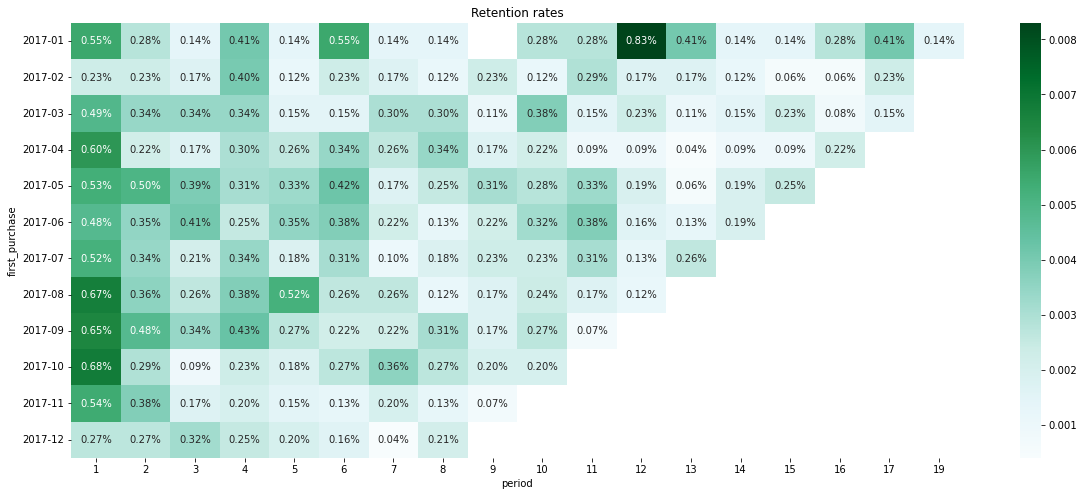

In [28]:
# визуализируем данные
plt.figure(figsize=(20, 8))
plt.title('Retention rates')
sns.heatmap(data = retention_table_plot, annot = True, fmt = '.2%',cmap = 'BuGn')
plt.show()

Когорта с самым высоким retention на 3й месяц - это покупатели, совершившие первую покупку в июне 2017. Retention 0,41%

### 6. Часто для качественного анализа аудитории используют подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. 
### Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. 

К датафрейму с покупателями добавим данные из таблицы с заказами, отфильтруем по покупкам.
Для подсчета Recency возьмем в качестве точки отсчета день следующий за днем последней покупки из датасета.

In [29]:
df = customers.merge(orders, how = 'left', on = 'customer_id')\
        .query('order_approved_at.isna() == False', engine='python')

# для каждого покупателя выводим последнюю дату его покупки
df['last_purchase'] = df.groupby('customer_unique_id').order_approved_at.transform(max)

today = df['order_approved_at'].max() + timedelta(days=1) # "точка отсчета"

# считаем Recency
df['recency'] = df['last_purchase'].apply(lambda x: (today - x).days)

In [30]:
# выделяем уникальных покупателей и их Recency
R = df.groupby('customer_unique_id', as_index=False).agg({'recency': 'min'})
R

,customer_unique_id,recency
0,0000366f3b9a7992bf8c76cfdf3221e2,117
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119
2,0000f46a3911fa3c0805444483337064,542
3,0000f6ccb0745a6a4b88665a16c9f078,326
4,0004aac84e0df4da2b147fca70cf8255,293
...,...,...
95992,fffcf5a5ff07b0908bd4e2dbc735a684,452
95993,fffea47cd6d3cc0a88bd621562a9d061,267
95994,ffff371b4d645b6ecea244b27531430a,574
95995,ffff5962728ec6157033ef9805bacc48,125


Для подсчета Frequency возьмем общее число покупок за весь период, по которому у нас есть данные. Поскольку подавляющее большинство покупателей совершило только одну покупку, на мой взгляд, среднее по неделям и месяцам будет не показательно.

In [31]:
F = df.groupby('customer_unique_id', as_index=False).agg({'order_id': 'count'})\
        .rename(columns={'order_id': 'frequency'})
F

,customer_unique_id,frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1
...,...,...
95992,fffcf5a5ff07b0908bd4e2dbc735a684,1
95993,fffea47cd6d3cc0a88bd621562a9d061,1
95994,ffff371b4d645b6ecea244b27531430a,1
95995,ffff5962728ec6157033ef9805bacc48,1


In [32]:
F.frequency.unique()

array([ 1,  2,  3,  4,  6,  7,  5,  9, 17], dtype=int64)

Для подсчета Monetary (суммы покупок за период) разделим посмотреть какие значения "чека клиента" встречаются и разделить их на три группы по процентилям (33) в зависимости от полученных данных

посчитаем сначала сумму каждого заказа. Потом эти данные добавим к df и посчитаем сумму покупок для каждого уникального покупателя.

In [33]:
price_of_order = items.groupby('order_id', as_index=False).agg({'price': 'sum'})

M = df.merge(price_of_order, how = 'left', on = 'order_id')\
            .groupby('customer_unique_id', as_index=False).agg({'price': 'sum'})\
            .rename(columns = {'price': 'monetary'})
M

,customer_unique_id,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90
2,0000f46a3911fa3c0805444483337064,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,25.99
4,0004aac84e0df4da2b147fca70cf8255,180.00
...,...,...
95992,fffcf5a5ff07b0908bd4e2dbc735a684,1570.00
95993,fffea47cd6d3cc0a88bd621562a9d061,64.89
95994,ffff371b4d645b6ecea244b27531430a,89.90
95995,ffff5962728ec6157033ef9805bacc48,115.00


In [34]:
# соединим три получившихся датафрейма в один
rfm = R.merge(F, how = 'left', on = 'customer_unique_id')\
    .merge(M, how = 'left', on = 'customer_unique_id')

In [35]:
rfm.frequency.unique()

array([ 1,  2,  3,  4,  6,  7,  5,  9, 17], dtype=int64)

In [36]:
rfm.shape

(95997, 4)

##### Объявим границы для сегментов. 
##### RECENCY. Как показал когортный анализ, ретеншн хоть и низкий, чаще всего повторно опкупают в первые три месяца. Поэтому первая группа будет  с покупками "до 90 дней". Вторая группа будет 90-365 дней, потому что в этот период еще есть шанс привлечь клиента к потоврной покупке (опять же судя по когортному анализу). И третий период - более года. Предположительно это клиенты, которым что-то не понравилось, и они не вернулсь.
##### FREQUENCY. В датасете очень много клиентов, которые купили всего один раз за весь период, выделим их в отдельную группу(1). Во второй группе будут пользователи, которые совершили 2-5 покупок, в третьей - 6 и выше.
##### MONETARY. Пользователей по сумме дохода от заказов разделим на три группы по отношению к перцентиилю колонки monetary (0.33).
##### С помощью такого разделения мы  сможем увидеть, с какими группами можно поработать, чтобы увеличить, н-р, ретеншн и лояльность

In [37]:
M.monetary.describe()

count    95997.000000
mean       141.566646
std        217.282723
min          0.000000
25%         46.400000
50%         89.000000
75%        154.170000
max      13440.000000
Name: monetary, dtype: float64

In [38]:
M.monetary.quantile(q=0.33)

56.99

In [39]:
groups = {'recency': {1: 90, 2: 365}, 'frequency': {1: 1, 2: 5}, 'monetary': {1: 56.99, 2: 113.98}}

In [40]:
# объявим функцию для присвоения рейтинга клиентам соответственно каждой группе
def r_score(x):
    if x <= groups['recency'][1]:
        return 3
    elif x <= groups['recency'][2]:
        return 2
    else:
        return 1

def fm_score(x, c):
    if x <= groups[c][1]:
        return 1
    elif x <= groups[c][2]:
        return 2
    else:
        return 3    

In [41]:
# проставим "рейтинг"
rfm['R'] = rfm['recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['frequency'].apply(lambda x: fm_score(x, 'frequency'))
rfm['M'] = rfm['monetary'].apply(lambda x: fm_score(x, 'monetary'))

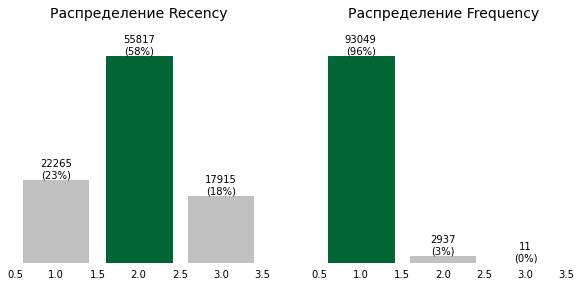

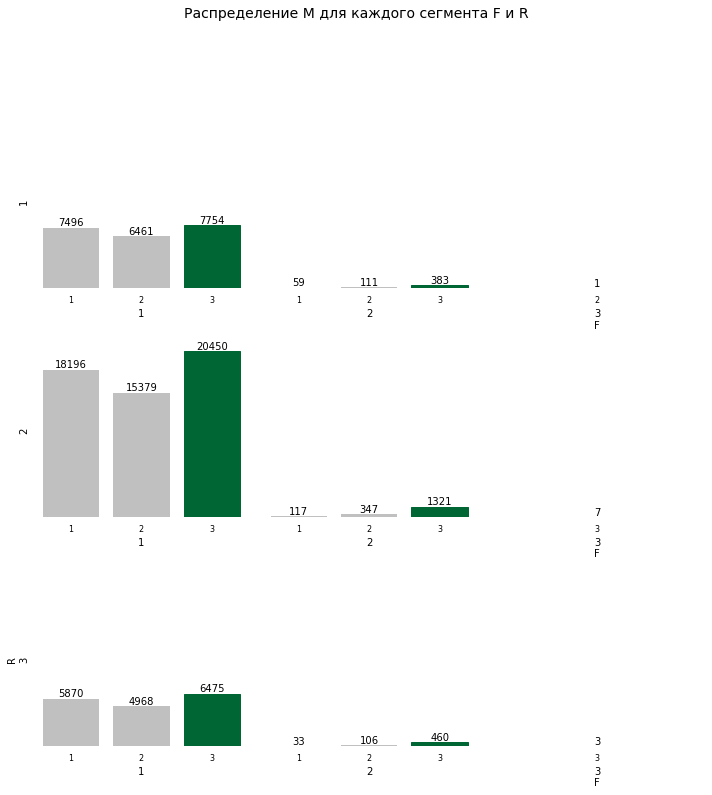

In [42]:
# визуализируем распределние покупателей по R И F
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

for i, p in enumerate(['R', 'F']):
    parameters = {'R':'Recency', 'F':'Frequency'}
    y = rfm[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='silver')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Распределение {}'.format(parameters[p]), y=1.1,
                fontsize=14)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('#006633')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha='center',
               va='bottom',
               color='k')

plt.show()

# визуализируем распределение покупателей по уровню приносимой выручки M для групп RF
fig, axes = plt.subplots(nrows=3, ncols=3,
                         sharex=False, sharey=True,
                         figsize=(10, 10))

r_range = range(1, 4)
f_range = range(1, 4)
for r in r_range:
    for f in f_range:
        y = rfm[(rfm['R'] == r) & (rfm['F'] == f)]['M'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y, color='silver')
        if f == 3:
            ax.set_xlabel('{}\nF'.format(f), va='top')
        else:
            ax.set_xlabel('{}\n'.format(f), va='top')
        if f == 1:
            if r == 3:
                ax.set_ylabel('R\n{}'.format(r))
            else:
                ax.set_ylabel(r)
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=8)

        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color('#006633')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='k')
fig.suptitle('Распределение M для каждого сегмента F и R', y=1.1,
             fontsize=14)
plt.tight_layout()
plt.show()

По этим графикам мы можем сказать, что больше всего наша выручка зависит от покупателей, которые купили что-то один раз, за счет их количества.

In [43]:
# склеим все ретинги в одно значение, которое будет обозначать сегмент
rfm['RFM_Score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm.head()

,customer_unique_id,recency,frequency,monetary,R,F,M,RFM_Score
0,0000366f3b9a7992bf8c76cfdf3221e2,117,1,129.90,2,1,3,213
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,2,1,1,211
2,0000f46a3911fa3c0805444483337064,542,1,69.00,1,1,2,112
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,2,1,1,211
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,2,1,3,213


In [44]:
# пропишем для каждого сегмента его название
d = {'RFM_Score': ['111',
 '112',
 '113',
 '121',
 '122',
 '123',
 '132',
 '211',
 '212',
 '213',
 '221',
 '222',
 '223',
 '233',
 '311',
 '312',
 '313',
 '321',
 '322',
 '323',
 '333'],
'Segment': ['Не зацепили: покупали больше года назад, 1 раз',
'Не зацепили: покупали больше года назад, 1 раз',
'Не зацепили: покупали больше года назад, 1 раз',
'Что-то пошло не так: покупали 2-5 раз, но больше года назад',
'Что-то пошло не так: покупали 2-5 раз, но больше года назад',
'Что-то пошло не так: покупали 2-5 раз, но больше года назад',
'Что-то пошло не так: покупали 2-5 раз, но больше года назад',
'Можно привлечь?: покупали 3-12 меяцев назад, 1 раз',
'Можно привлечь?: покупали 3-12 меяцев назад, 1 раз',
'Можно привлечь?: покупали 3-12 меяцев назад, 1 раз',
'Требуют внимания: покупали несколько раз, с низким или средним чеком, но больше 3 меяцев не покупали',
'Требуют внимания: покупали несколько раз, с низким или средним чеком, но больше 3 меяцев не покупали',
'Требуют внимания: покупали несколько раз, с большим чеком, но больше 3 меяцев не покупали',
'Требуют внимания: покупали больше 5 раз, с большим чеком, но больше 3 меяцев не покупали',
'Новые клиенты: покупали менее 3 меяцев назад, один раз',
'Новые клиенты: покупали менее 3 меяцев назад, один раз',
'Новые клиенты: покупали менее 3 меяцев назад, один раз',
'Лояльные: покупали несколько раз, менее 3 меяцев назад, с низким или средним чеком',
'Лояльные: покупали несколько раз, менее 3 меяцев назад, с низким или средним чеком',
'Покупали менее 3 меяцев назад, 2 - 4 раза, платят много',
'Покупали менее 3 меяцев назад, более 5 раз, платят много']}

dfdf = pd.DataFrame(d)

In [45]:
# дополним наш датафрейм этими названием, и проверим, что все приклеилось правльно
rfm = rfm.merge(dfdf, how = 'inner', on = 'RFM_Score')
rfm.isna().sum()

customer_unique_id    0
recency               0
frequency             0
monetary              0
R                     0
F                     0
M                     0
RFM_Score             0
Segment               0
dtype: int64

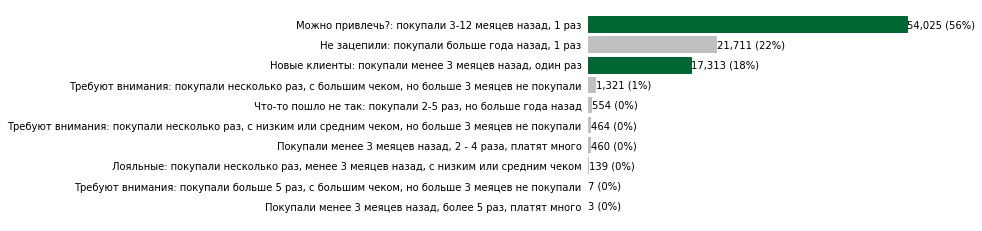

In [47]:
# посчитаем и визуализируем количество покупателей в кадом сегменте
segments_counts = rfm['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['Новые клиенты: покупали менее 3 меяцев назад, один раз', 'Можно привлечь?: покупали 3-12 меяцев назад, 1 раз']:
            bar.set_color('#006633')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()


##### Вывыод можно сделать следующий. Мы видим, что у нас подавляющее большинство клиентов совершило только одну покупку. Объективно на привлечение новых клиентов мы тратим больше денег, чем если бы возвращались старые.
##### На мой взгляд следующим шагом можно было бы проанализировать ассортимент товаров. Возможно, у нас такие товары, которые требуются раз в несколько лет. Может быть мы модем дополнить наш ассртимент, как автомобильные дилеры, продавая запчасти.
##### Другой вариант, как мы можем поработать с группами, выделенными, зеленым, теми, кто покупал один раз но в течение года. Подумать, как мы их можем привлечь, для повышения их лояльности.